# FDA Food Adverse Events - Data Exploration

This notebook explores the FDA openFDA food adverse event reports dataset to understand:
- Dataset structure and quality
- Temporal patterns in adverse event reports
- Most common reactions and outcomes
- Consumer demographics
- Product categories involved

**Goal**: Identify patterns that will inform our anomaly detection approach for outbreak identification.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [2]:
# Import our custom data loader
import sys
sys.path.append('../src')
from data_loader import FDADataLoader

## 1. Load the Data

We'll start by loading a subset of the data to explore its structure. The full dataset contains 2.6M+ records, so we'll initially work with a manageable sample.

In [3]:
# Initialize data loader
data_path = '../data/raw/food-event-0001-of-0001.json'
loader = FDADataLoader(data_path)

# Load sample of data (adjust max_records as needed)
print("Loading data sample...")
df = loader.load_to_dataframe(max_records=50000)
print(f"Loaded {len(df):,} records")

INFO:data_loader:Loading FDA data to DataFrame...


Loading data sample...


INFO:data_loader:Processed 10000 records...
INFO:data_loader:Processed 20000 records...
INFO:data_loader:Processed 30000 records...
INFO:data_loader:Processed 40000 records...
INFO:data_loader:Processed 50000 records...
INFO:data_loader:Loaded 50000 records into DataFrame


Loaded 50,000 records


In [4]:
# Display basic information
print("Dataset shape:", df.shape)
print("\nColumn names and types:")
df.info()

Dataset shape: (50000, 14)

Column names and types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   report_number      50000 non-null  object
 1   date_created       50000 non-null  object
 2   date_started       31018 non-null  object
 3   outcomes           50000 non-null  object
 4   reactions          50000 non-null  object
 5   reaction_count     50000 non-null  int64 
 6   consumer_age       29057 non-null  object
 7   consumer_age_unit  29057 non-null  object
 8   consumer_gender    45469 non-null  object
 9   product_name       50000 non-null  object
 10  product_role       50000 non-null  object
 11  industry_code      50000 non-null  object
 12  industry_name      50000 non-null  object
 13  products           50000 non-null  object
dtypes: int64(1), object(13)
memory usage: 5.3+ MB


## 2. Convert Data Types

Convert date and numeric columns to appropriate types for analysis.

In [5]:
# Convert date columns
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y%m%d', errors='coerce')
df['date_started'] = pd.to_datetime(df['date_started'], format='%Y%m%d', errors='coerce')

# Convert consumer_age to numeric (it's stored as string in JSON)
df['consumer_age'] = pd.to_numeric(df['consumer_age'], errors='coerce')

print("Data types after conversion:")
print(df[['date_created', 'date_started', 'consumer_age']].dtypes)
print(f"\nRecords with valid date_started: {df['date_started'].notna().sum():,}")
print(f"Records with valid consumer_age: {df['consumer_age'].notna().sum():,}")

Data types after conversion:
date_created    datetime64[ns]
date_started    datetime64[ns]
consumer_age           float64
dtype: object

Records with valid date_started: 31,018
Records with valid consumer_age: 29,057


In [6]:
# View first few records
df.head(10)

,report_number,date_created,date_started,outcomes,reactions,reaction_count,consumer_age,consumer_age_unit,consumer_gender,product_name,product_role,industry_code,industry_name,products
0,102518,2008-04-04,2008-03-27,[Visited a Health Care Provider],"[ABDOMINAL PAIN, DIARRHOEA, NAUSEA, VOMITING]",4,NaN,None,None,"OMEGA BERRY FISH OIL TABLETS, SOFT GEL CAPSULE...",SUSPECT,54,Vit/Min/Prot/Unconv Diet(Human/Animal),"[OMEGA BERRY FISH OIL TABLETS, SOFT GEL CAPSUL..."
1,103085,2008-05-07,2008-03-20,[Hospitalization],"[BLISTER, ECCHYMOSIS, EPISTAXIS, GASTROINTESTI...",7,69.0,year(s),Female,NUTRITIONAL SCIENCE LABS HYPERZOSIN,SUSPECT,54,Vit/Min/Prot/Unconv Diet(Human/Animal),[NUTRITIONAL SCIENCE LABS HYPERZOSIN]
2,107997,2008-11-21,NaT,"[Other Serious or Important Medical Event, Oth...","[CHOKING, REMOVAL OF FOREIGN BODY FROM THROAT]",2,84.0,year(s),Female,OS CAL (CALCIUM CARBONATE PLUS VITAMIN D),SUSPECT,54,Vit/Min/Prot/Unconv Diet(Human/Animal),[OS CAL (CALCIUM CARBONATE PLUS VITAMIN D)]
3,104921,2008-07-10,NaT,[Visited a Health Care Provider],"[BREATH ODOUR, HYPERSENSITIVITY]",2,NaN,None,Female,STOFFER'S FRENCH BREAD PIZZA - GRILLED VEGETABLES,SUSPECT,37,Mult Food Dinner/Grav/Sauce/Special,[STOFFER'S FRENCH BREAD PIZZA - GRILLED VEGETA...
4,110847,2009-03-03,NaT,[Other Outcome],"[BURNING SENSATION, HYPOAESTHESIA]",2,NaN,None,Female,MAGNETIC SPRINGS DISTILLED WATER,SUSPECT,29,Soft Drink/Water,[MAGNETIC SPRINGS DISTILLED WATER]
5,108592,2008-12-17,2008-12-03,"[Other Serious or Important Medical Event, Oth...","[ABDOMINAL DISTENSION, FAECES DISCOLOURED, HAE...",3,73.0,year(s),Female,PHILLIPS' COLON HEALTH (LACTOBACILLUS COMPOUND),SUSPECT,54,Vit/Min/Prot/Unconv Diet(Human/Animal),[PHILLIPS' COLON HEALTH (LACTOBACILLUS COMPOUND)]
6,107203,2008-10-16,2008-10-11,"[Hospitalization, Other Serious or Important M...",[ABORTION SPONTANEOUS],1,28.0,year(s),Female,NATAFORT PRENATAL VITAMINS,SUSPECT,54,Vit/Min/Prot/Unconv Diet(Human/Animal),[NATAFORT PRENATAL VITAMINS]
7,109576,2009-01-27,2009-01-11,[Other Outcome],"[DIARRHOEA, MALAISE, VOMITING]",3,NaN,None,Male,AUSTIN PEANUT BUTTER CRACKERS (CHEESE AND TOASTY),SUSPECT,03,Bakery Prod/Dough/Mix/Icing,[AUSTIN PEANUT BUTTER CRACKERS (CHEESE AND TOA...
8,118649,2008-12-09,2008-12-03,[Other Outcome],"[DIZZINESS, NAUSEA, PARAESTHESIA]",3,NaN,None,Male,PEPSI COLA DR PEPPER,SUSPECT,29,Soft Drink/Water,[PEPSI COLA DR PEPPER]
9,111858,2009-01-21,2009-01-20,[Other Outcome],"[ABDOMINAL PAIN, DIARRHOEA, MALAISE, VOMITING]",4,NaN,None,Male,PILLSBURY BIG DELUXE PEANUT BUTTER CUP COOKIES,SUSPECT,03,Bakery Prod/Dough/Mix/Icing,[PILLSBURY BIG DELUXE PEANUT BUTTER CUP COOKIES]


## 3. Data Quality Assessment

In [7]:
# Check for missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Percentage', ascending=False)

print("Missing Data Summary:")
print(missing_data[missing_data['Missing_Count'] > 0])

Missing Data Summary:
                              Column  Missing_Count  Missing_Percentage
consumer_age_unit  consumer_age_unit          20943               41.89
consumer_age            consumer_age          20943               41.89
date_started            date_started          18982               37.96
consumer_gender      consumer_gender           4531                9.06


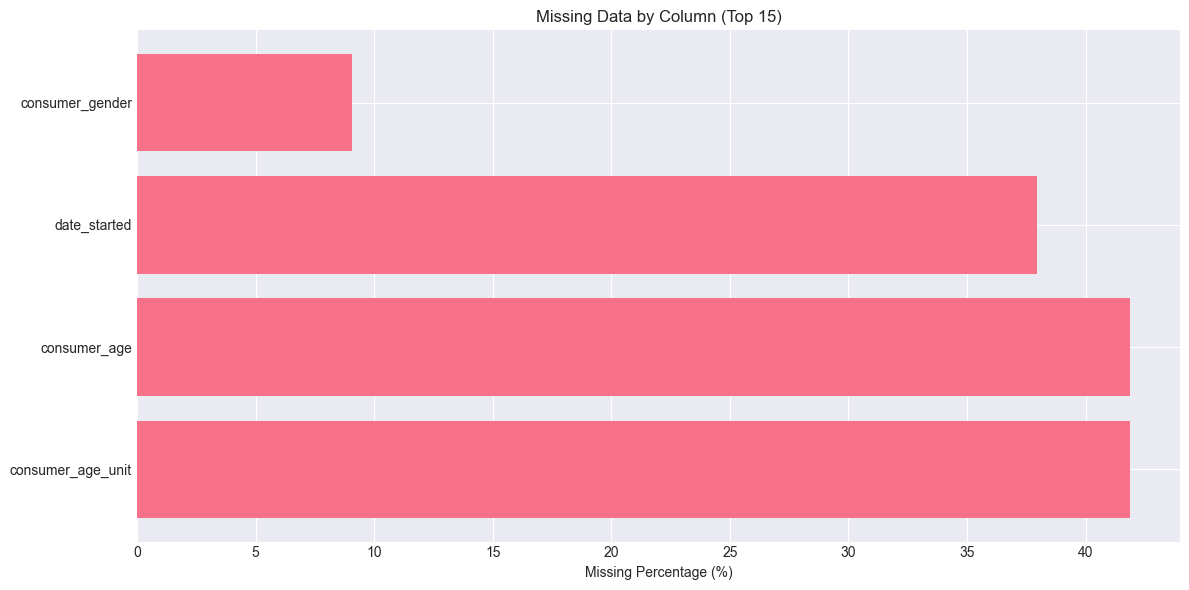

In [8]:
# Visualize missing data
plt.figure(figsize=(12, 6))
missing_cols = missing_data[missing_data['Missing_Percentage'] > 0].head(15)
plt.barh(missing_cols['Column'], missing_cols['Missing_Percentage'])
plt.xlabel('Missing Percentage (%)')
plt.title('Missing Data by Column (Top 15)')
plt.tight_layout()
plt.show()

In [9]:
# Check for duplicate report numbers
duplicates = df['report_number'].duplicated().sum()
print(f"Duplicate report numbers: {duplicates:,}")
print(f"Unique reports: {df['report_number'].nunique():,}")

Duplicate report numbers: 0
Unique reports: 50,000


## 4. Temporal Analysis

Understanding the time distribution of reports is crucial for outbreak detection.

In [10]:
# Convert date_started to datetime
df['date_started'] = pd.to_datetime(df['date_started'], errors='coerce')

# Extract temporal features
df['year'] = df['date_started'].dt.year
df['month'] = df['date_started'].dt.month
df['day_of_week'] = df['date_started'].dt.dayofweek
df['quarter'] = df['date_started'].dt.quarter

print("Date range:")
print(f"Earliest: {df['date_started'].min()}")
print(f"Latest: {df['date_started'].max()}")
print(f"Missing dates: {df['date_started'].isna().sum():,}")

Date range:
Earliest: 1925-01-23 00:00:00
Latest: 2025-03-29 00:00:00
Missing dates: 18,982


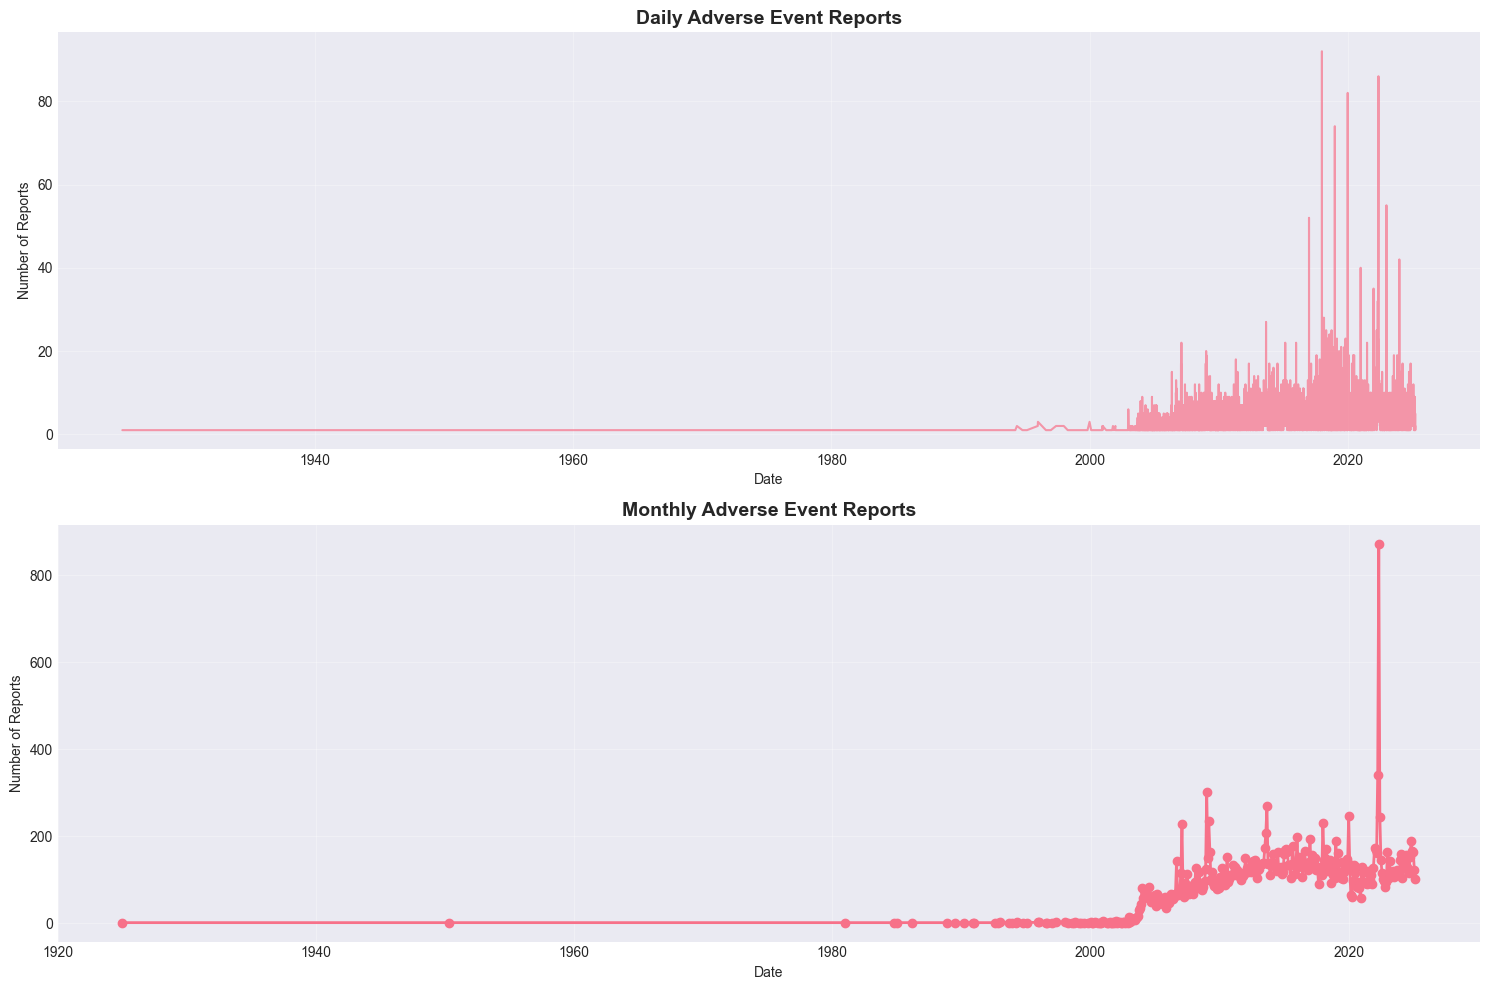

In [11]:
# Plot reports over time
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Daily counts
daily_counts = df.groupby(df['date_started'].dt.date).size()
axes[0].plot(daily_counts.index, daily_counts.values, alpha=0.7)
axes[0].set_title('Daily Adverse Event Reports', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Reports')
axes[0].grid(True, alpha=0.3)

# Monthly counts
monthly_counts = df.groupby(df['date_started'].dt.to_period('M')).size()
monthly_counts.index = monthly_counts.index.to_timestamp()
axes[1].plot(monthly_counts.index, monthly_counts.values, marker='o', linewidth=2)
axes[1].set_title('Monthly Adverse Event Reports', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Reports')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

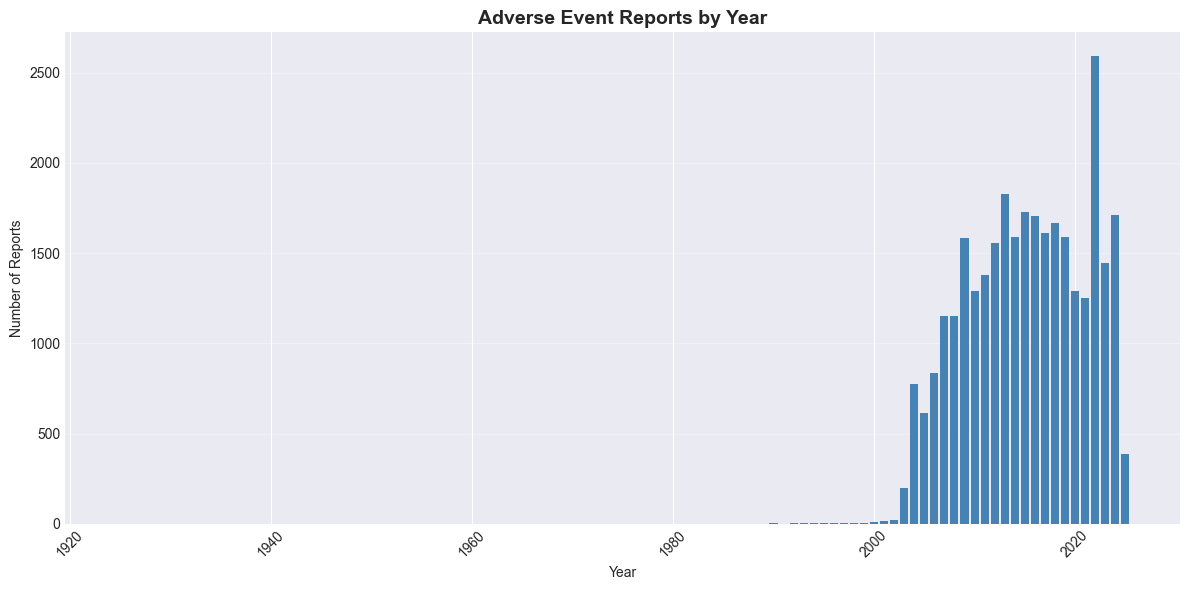


Yearly Report Counts:
year
1925.0       1
1950.0       1
1981.0       1
1984.0       1
1985.0       1
1986.0       1
1988.0       1
1989.0       1
1990.0       2
1991.0       1
1992.0       2
1993.0       4
1994.0       4
1995.0       3
1996.0       5
1997.0       3
1998.0       7
1999.0       4
2000.0      12
2001.0      16
2002.0      19
2003.0     198
2004.0     774
2005.0     616
2006.0     838
2007.0    1149
2008.0    1153
2009.0    1583
2010.0    1291
2011.0    1380
2012.0    1556
2013.0    1826
2014.0    1591
2015.0    1728
2016.0    1704
2017.0    1610
2018.0    1667
2019.0    1587
2020.0    1288
2021.0    1254
2022.0    2594
2023.0    1445
2024.0    1709
2025.0     387
Name: count, dtype: int64


In [12]:
# Yearly trend
yearly_counts = df['year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(yearly_counts.index, yearly_counts.values, color='steelblue')
plt.title('Adverse Event Reports by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Reports')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nYearly Report Counts:")
print(yearly_counts)

## 5. Reaction Analysis

Identifying the most common reactions will help us focus our anomaly detection efforts.

In [13]:
# Count reactions (handling lists)
from collections import Counter

all_reactions = []
for reactions in df['reactions'].dropna():
    if isinstance(reactions, list):
        all_reactions.extend(reactions)
    elif isinstance(reactions, str):
        all_reactions.append(reactions)

reaction_counts = Counter(all_reactions)
top_reactions = pd.DataFrame(reaction_counts.most_common(30), 
                             columns=['Reaction', 'Count'])

print(f"Total unique reactions: {len(reaction_counts):,}")
print(f"Total reaction occurrences: {len(all_reactions):,}")
print("\nTop 30 Most Common Reactions:")
print(top_reactions)

Total unique reactions: 5,605
Total reaction occurrences: 159,646

Top 30 Most Common Reactions:
                Reaction  Count
0              DIARRHOEA   6605
1               VOMITING   5523
2                 NAUSEA   4587
3              Diarrhoea   4526
4         ABDOMINAL PAIN   3853
5               Vomiting   3646
6                 Nausea   3142
7                MALAISE   2705
8                CHOKING   2365
9               HEADACHE   2044
10        Abdominal pain   1899
11  ABDOMINAL PAIN UPPER   1771
12              DYSPNOEA   1659
13      HYPERSENSITIVITY   1602
14             DIZZINESS   1563
15               Malaise   1485
16  Abdominal pain upper   1432
17              Headache   1430
18               Pyrexia   1170
19             DYSPHAGIA   1148
20               Choking   1129
21               Fatigue   1109
22             Dizziness   1029
23               FATIGUE   1011
24      Hypersensitivity   1000
25              Dyspnoea    991
26                  PAIN    981
27     

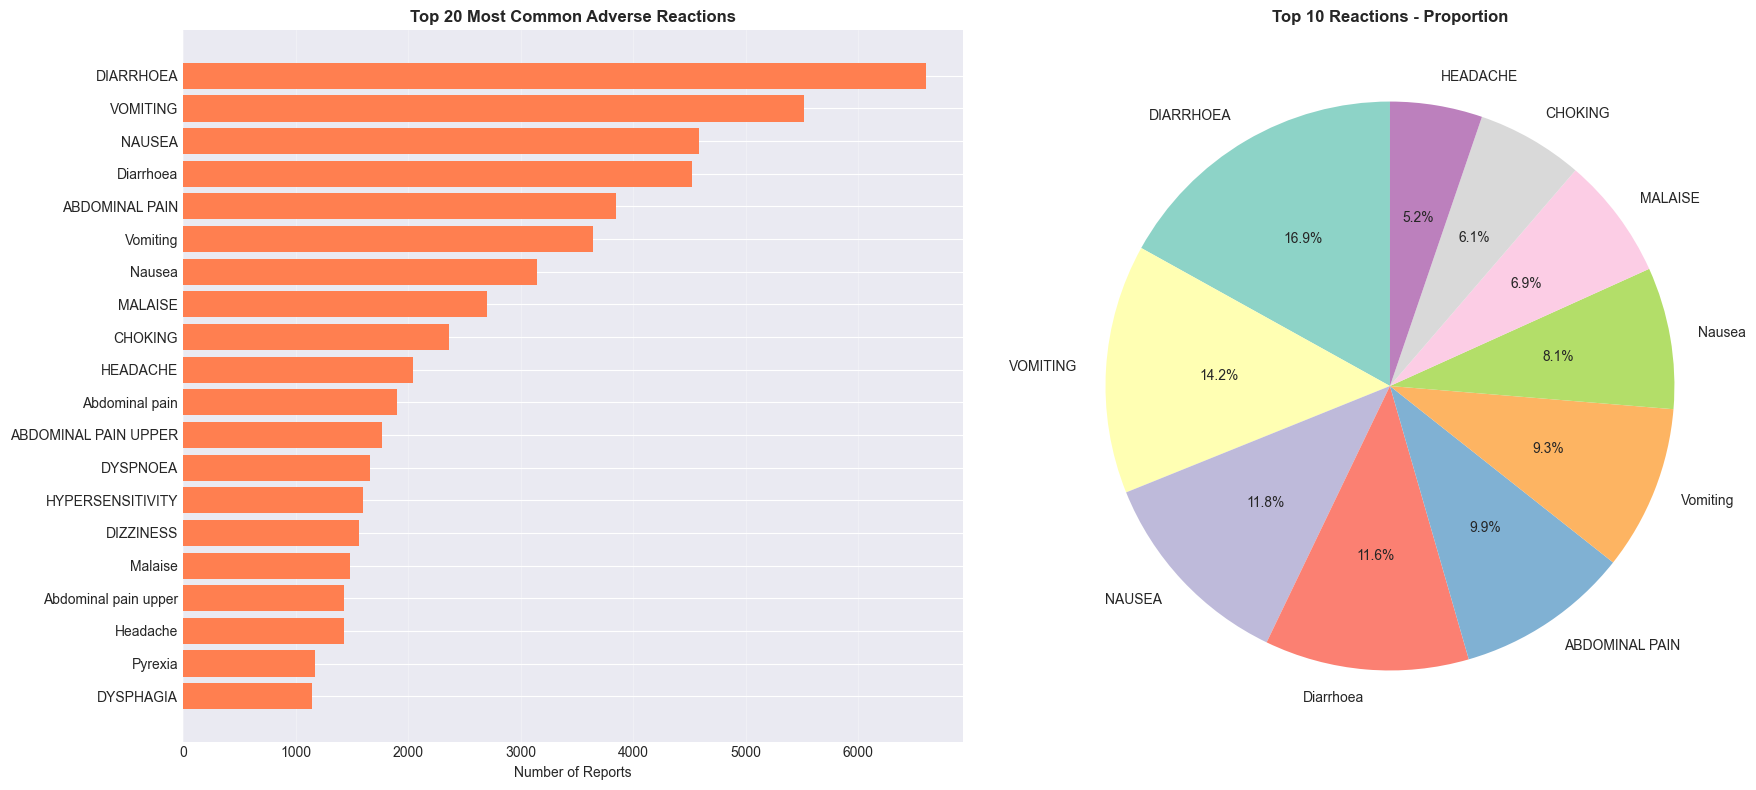

In [14]:
# Visualize top reactions
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Top 20 reactions
top_20 = top_reactions.head(20)
axes[0].barh(range(len(top_20)), top_20['Count'], color='coral')
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['Reaction'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Number of Reports')
axes[0].set_title('Top 20 Most Common Adverse Reactions', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Top 10 with percentages
top_10 = top_reactions.head(10).copy()
top_10['Percentage'] = (top_10['Count'] / len(all_reactions) * 100).round(2)
colors = plt.cm.Set3(range(len(top_10)))
axes[1].pie(top_10['Count'], labels=top_10['Reaction'], autopct='%1.1f%%',
           startangle=90, colors=colors)
axes[1].set_title('Top 10 Reactions - Proportion', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Outcome Analysis

In [15]:
# Analyze outcomes
all_outcomes = []
for outcomes in df['outcomes'].dropna():
    if isinstance(outcomes, list):
        all_outcomes.extend(outcomes)
    elif isinstance(outcomes, str):
        all_outcomes.append(outcomes)

outcome_counts = Counter(all_outcomes)
outcome_df = pd.DataFrame(outcome_counts.most_common(), 
                         columns=['Outcome', 'Count'])
outcome_df['Percentage'] = (outcome_df['Count'] / len(all_outcomes) * 100).round(2)

print("Outcome Distribution:")
print(outcome_df)

Outcome Distribution:
                                     Outcome  Count  Percentage
0   Other Serious or Important Medical Event  23826       33.86
1                              Other Outcome  11521       16.37
2                            Hospitalization   8624       12.26
3             Visited a Health Care Provider   7695       10.94
4                     Visited Emergency Room   6908        9.82
5                      Other Serious Outcome   3819        5.43
6                           Life Threatening   3065        4.36
7                                 Disability   2277        3.24
8                      Required Intervention   1081        1.54
9                                      Death    879        1.25
10                         Allergic Reaction    540        0.77
11                                    Injury     69        0.10
12                        Congenital Anomaly     58        0.08


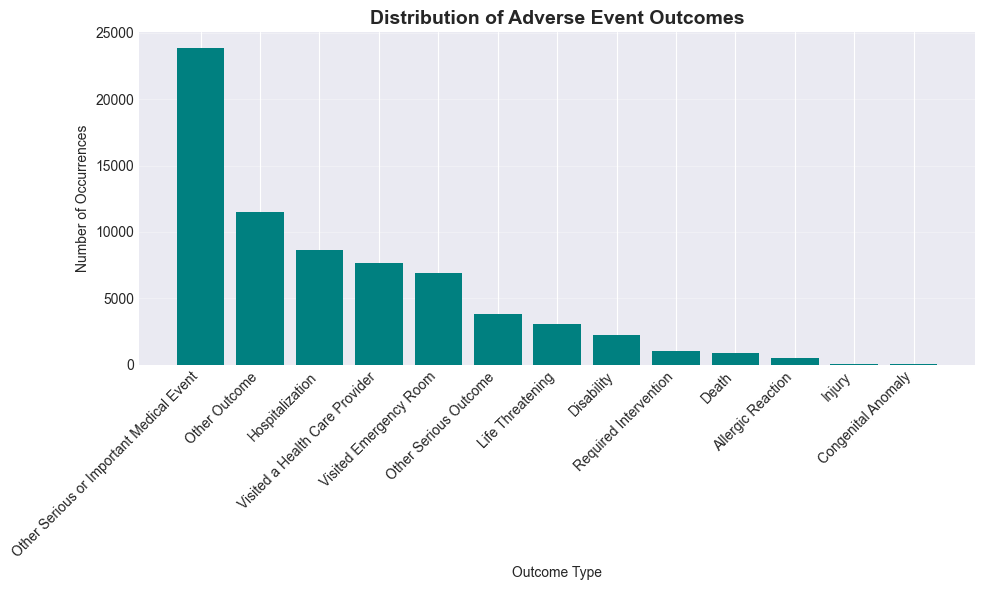

In [16]:
# Visualize outcomes
plt.figure(figsize=(10, 6))
plt.bar(outcome_df['Outcome'], outcome_df['Count'], color='teal')
plt.title('Distribution of Adverse Event Outcomes', fontsize=14, fontweight='bold')
plt.xlabel('Outcome Type')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 7. Consumer Demographics

In [17]:
# Age analysis

age_data = df['consumer_age'].dropna()

print(f"Age statistics:")
print(f"Mean: {age_data.mean():.1f} years")
print(f"Median: {age_data.median():.1f} years")
print(f"Min: {age_data.min():.1f} years")
print(f"Max: {age_data.max():.1f} years")
print(f"Std: {age_data.std():.1f} years")

Age statistics:
Mean: 48.2 years
Median: 50.0 years
Min: 1.0 years
Max: 365.0 years
Std: 24.4 years


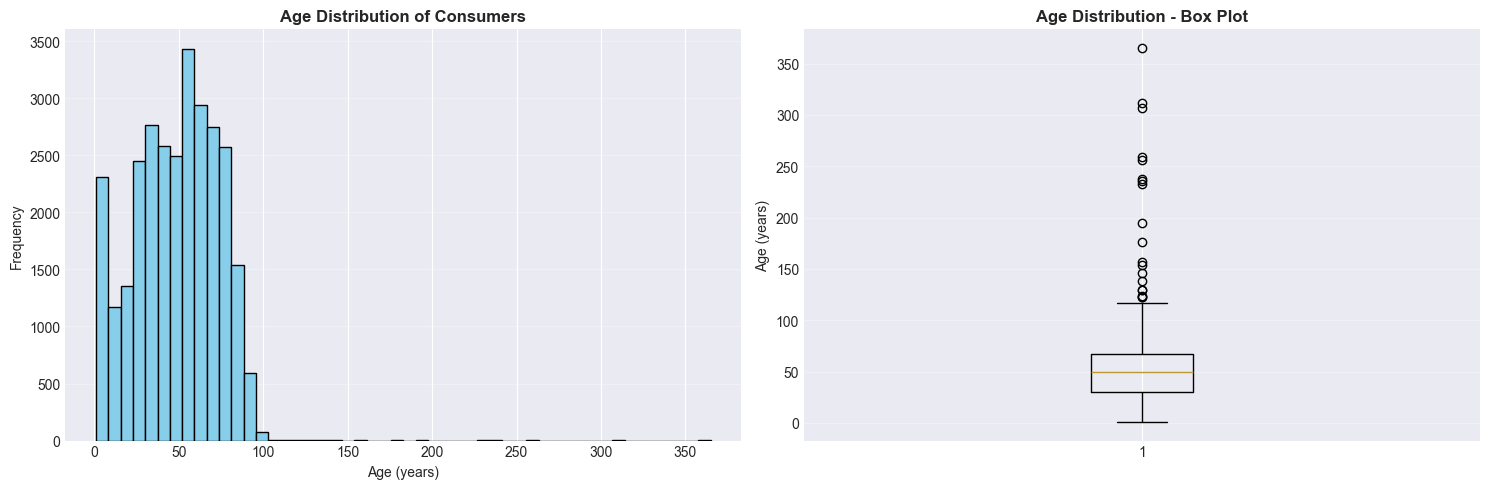

In [18]:
# Age distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(age_data, bins=50, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Age Distribution of Consumers', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Box plot
axes[1].boxplot(age_data, vert=True)
axes[1].set_ylabel('Age (years)')
axes[1].set_title('Age Distribution - Box Plot', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

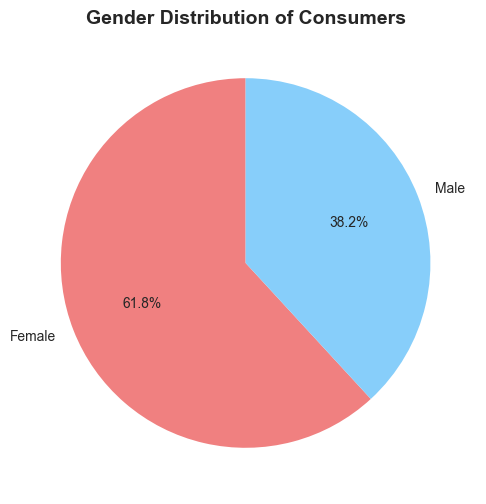


Gender Counts:
consumer_gender
Female    28121
Male      17348
Name: count, dtype: int64


In [19]:
# Gender distribution
gender_counts = df['consumer_gender'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
       startangle=90, colors=['lightcoral', 'lightskyblue', 'lightgray'])
plt.title('Gender Distribution of Consumers', fontsize=14, fontweight='bold')
plt.show()

print("\nGender Counts:")
print(gender_counts)

## 8. Product Analysis

In [20]:
# Top products/brands involved
products = df['product_name'].dropna()
product_list = []

for prod in products:
    if isinstance(prod, str) and prod != 'None':
        product_list.append(prod)

product_counts = Counter(product_list)
top_products = pd.DataFrame(product_counts.most_common(20),
                           columns=['Product', 'Count'])

print(f"Unique products: {len(product_counts):,}")
print("\nTop 20 Products:")
print(top_products)

Unique products: 31,652

Top 20 Products:
                                              Product  Count
0                                         EXEMPTION 4    746
1                                 SUPER BETA PROSTATE    564
2                                PRESERVISION AREDS 2    433
3                            JIF CREAMY PEANUT BUTTER    428
4   CENTRUM SILVER WOMEN'S 50+ (MULTIMINERALS, MUL...    328
5                                   JIF PEANUT BUTTER    260
6                                    CITRACAL MAXIMUM    221
7                          GENERAL MILLS LUCKY CHARMS    218
8                                              KRATOM    195
9                      PETER PAN CREAMY PEANUT BUTTER    181
10             PRESERVISION AREDS 2 FORMULA SOFT GELS    171
11                                        RAW OYSTERS    140
12           HYDROXYCUT REGULAR RAPID RELEASE CAPLETS    121
13                         CENTRUM SILVER WOMEN'S 50+    116
14                    SUPER BETA PROSTATE P

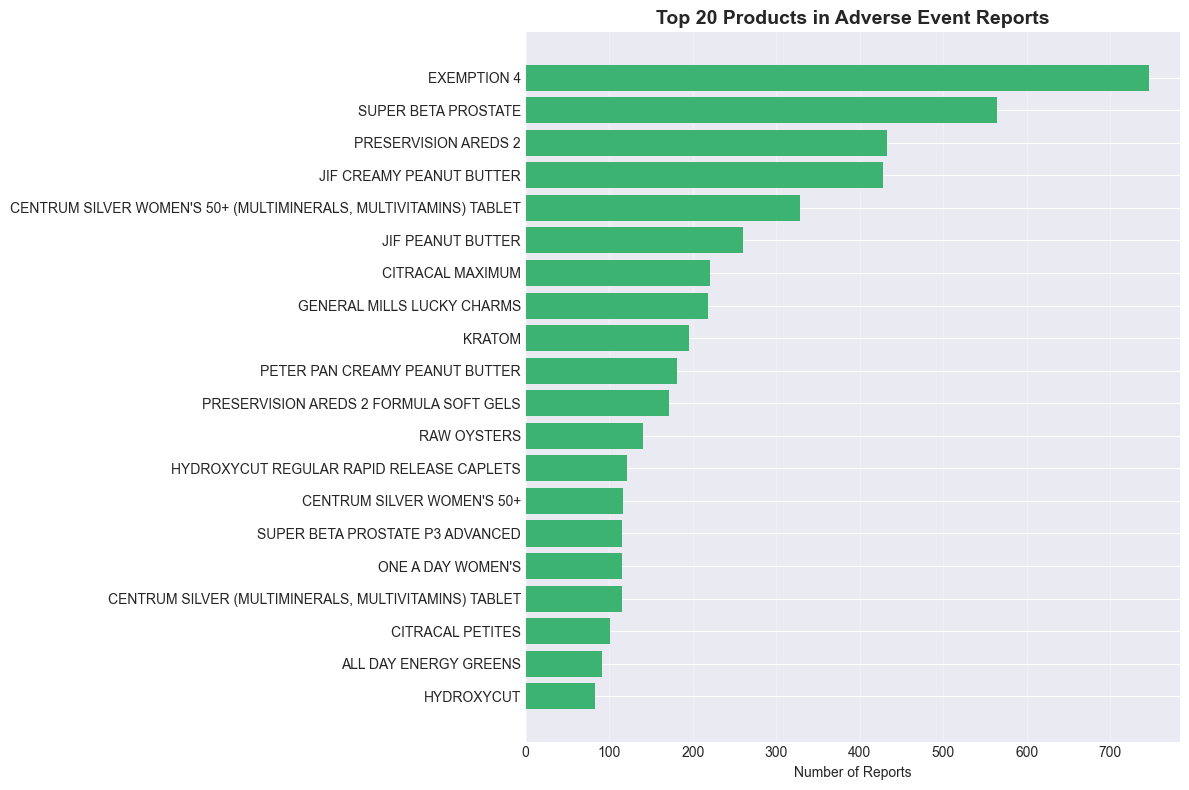

In [21]:
# Visualize top products
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_products)), top_products['Count'], color='mediumseagreen')
plt.yticks(range(len(top_products)), top_products['Product'])
plt.gca().invert_yaxis()
plt.xlabel('Number of Reports')
plt.title('Top 20 Products in Adverse Event Reports', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 9. Time Series by Reaction Type

This is crucial for outbreak detection - we want to see how specific reactions trend over time.

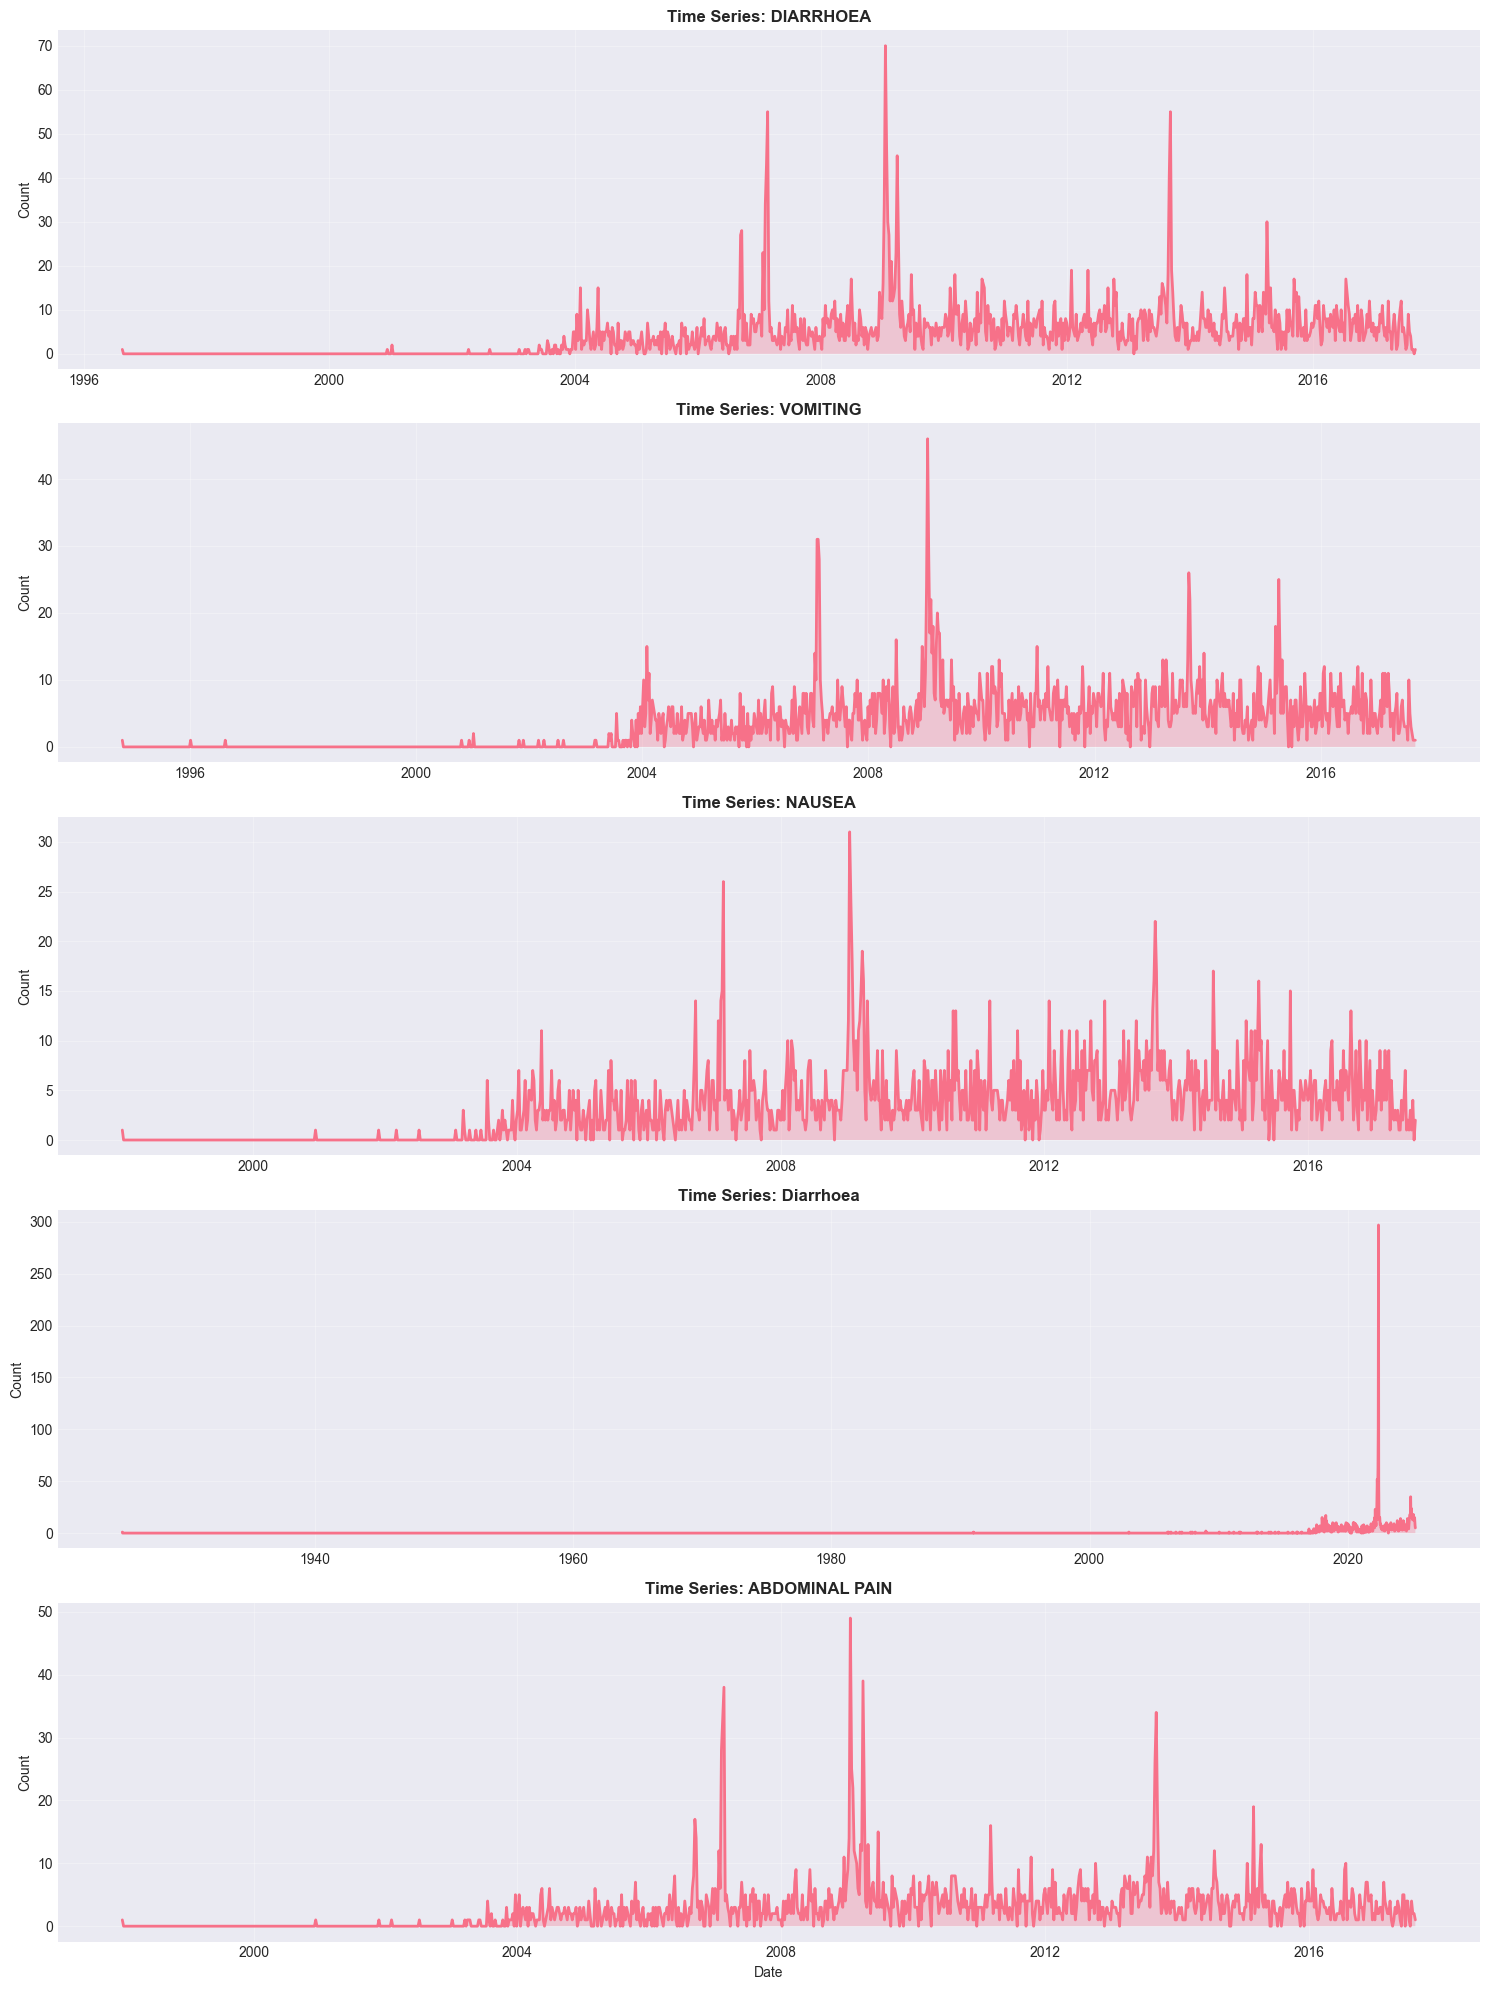

In [22]:
# Create a function to plot time series for specific reactions
def plot_reaction_timeseries(df, reactions, freq='W'):
    """
    Plot time series for specific reactions
    
    Args:
        df: DataFrame with 'date_started' and 'reactions'
        reactions: List of reaction names to plot
        freq: Frequency for aggregation ('D'=daily, 'W'=weekly, 'M'=monthly)
    """
    fig, axes = plt.subplots(len(reactions), 1, figsize=(15, 4*len(reactions)))
    if len(reactions) == 1:
        axes = [axes]
    
    for idx, reaction in enumerate(reactions):
        # Filter for this reaction
        reaction_mask = df['reactions'].apply(
            lambda x: reaction in x if isinstance(x, list) else reaction == x
        )
        reaction_df = df[reaction_mask].copy()
        
        # Aggregate by time period
        ts = reaction_df.groupby(pd.Grouper(key='date_started', freq=freq)).size()
        
        # Plot
        axes[idx].plot(ts.index, ts.values, linewidth=2)
        axes[idx].set_title(f'Time Series: {reaction}', fontweight='bold', fontsize=12)
        axes[idx].set_ylabel('Count')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].fill_between(ts.index, ts.values, alpha=0.3)
    
    axes[-1].set_xlabel('Date')
    plt.tight_layout()
    plt.show()

# Plot top 5 reactions
top_5_reactions = top_reactions.head(5)['Reaction'].tolist()
plot_reaction_timeseries(df, top_5_reactions, freq='W')

## 10. Key Insights Summary

In [23]:
print("=" * 80)
print("KEY INSIGHTS FROM EXPLORATION")
print("=" * 80)
print(f"\n1. DATASET SIZE")
print(f"   - Total records analyzed: {len(df):,}")
print(f"   - Date range: {df['date_started'].min()} to {df['date_started'].max()}")
print(f"   - Unique reports: {df['report_number'].nunique():,}")

print(f"\n2. REACTIONS")
print(f"   - Unique reaction types: {len(reaction_counts):,}")
print(f"   - Most common: {top_reactions.iloc[0]['Reaction']} ({top_reactions.iloc[0]['Count']:,} reports)")
print(f"   - Top 5 reactions account for significant portion of reports")

print(f"\n3. TEMPORAL PATTERNS")
print(f"   - Reports appear to have seasonal/temporal variation")
print(f"   - Some spikes visible in time series plots")
print(f"   - Further investigation needed for anomaly detection")

print(f"\n4. OUTCOMES")
if len(outcome_df) > 0:
    print(f"   - Most common outcome: {outcome_df.iloc[0]['Outcome']} ({outcome_df.iloc[0]['Percentage']:.1f}%)")
    print(f"   - Serious outcomes present in dataset")

print(f"\n5. NEXT STEPS")
print(f"   - Implement data preprocessing pipeline")
print(f"   - Focus on top 10-20 reactions for anomaly detection")
print(f"   - Develop baseline statistical models")
print(f"   - Implement machine learning anomaly detectors")
print("\n" + "=" * 80)

KEY INSIGHTS FROM EXPLORATION

1. DATASET SIZE
   - Total records analyzed: 50,000
   - Date range: 1925-01-23 00:00:00 to 2025-03-29 00:00:00
   - Unique reports: 50,000

2. REACTIONS
   - Unique reaction types: 5,605
   - Most common: DIARRHOEA (6,605 reports)
   - Top 5 reactions account for significant portion of reports

3. TEMPORAL PATTERNS
   - Reports appear to have seasonal/temporal variation
   - Some spikes visible in time series plots
   - Further investigation needed for anomaly detection

4. OUTCOMES
   - Most common outcome: Other Serious or Important Medical Event (33.9%)
   - Serious outcomes present in dataset

5. NEXT STEPS
   - Implement data preprocessing pipeline
   - Focus on top 10-20 reactions for anomaly detection
   - Develop baseline statistical models
   - Implement machine learning anomaly detectors



## 11. Save Processed Data (Optional)

Save the explored dataset for use in subsequent notebooks.

In [24]:
# Save to processed data folder
output_path = '../data/processed/explored_sample.parquet'
df.to_parquet(output_path, compression='snappy', index=False)
print(f"Saved explored data to: {output_path}")
print(f"File size: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Saved explored data to: ../data/processed/explored_sample.parquet
File size: 37.41 MB
